## Import packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'  # 安装graphviz的路径，用于模型可视化

In [3]:
import keras
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU, BatchNormalization, RepeatVector, Lambda
from keras.layers.merge import concatenate, multiply, dot
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, TimeDistributed
from keras.models import Model, Sequential
from keras import optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.engine.topology import Layer
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

Using TensorFlow backend.


## Hyper parameter setting

In [4]:
token = 'words' # based on words or chars
embed_size = 300 # how big is each word vector
max_features = 20890 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 40 # max number of words in a comment to use
num_rnn_units = 128 # output dim for LSTM or GRU
num_hidden_units = 200 # output dim for dense layer
drop_prob = 0.2
max_norm = 5.0 # gradient clipping
mp = 5 # multi-perspective matching

## File path

In [5]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'
QUESTION_PATH = './question.csv'
embed_files = {'words': './word_embed.txt', 'chars': './char_embed.txt'}

## Some helper function

In [6]:
# Get question id from a list. Remove the Q
def get_ids(qids):
    ids = []
    for t_ in qids:
        ids.append(int(t_[1:]))
    return np.asarray(ids)

# Get the text
def get_texts(q_list, question_path=QUESTION_PATH):
    qes = pd.read_csv(question_path)
    ids = get_ids(q_list)
    all_tokens = qes[token]
    texts = [all_tokens[t] for t in ids]
    return texts

## Read the text

#### Train data
split some data for validation

In [7]:
train = pd.read_csv(TRAIN_PATH)
list_train = list(zip(train['q1'], train['q2']))
label_train = train['label']
#print(len(list_train), len(label_train))

X_tra, X_val, y_tra, y_val = train_test_split(list_train, label_train, train_size=0.85, random_state=8, shuffle=True)

# get the text list of question 1 and 2
q1_train = [i[0] for i in X_tra]
text1_train = get_texts(q1_train)
q2_train = [i[1] for i in X_tra]
text2_train = get_texts(q2_train)
q1_val = [i[0] for i in X_val]
text1_val = get_texts(q1_val)
q2_val = [i[1] for i in X_val]
text2_val = get_texts(q2_val)

C:\Users\SJ\AppData\Local\conda\conda\envs\deep\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Test data

In [8]:
test = pd.read_csv(TEST_PATH)
list_test = list(zip(test['q1'], test['q2']))

# get the text list of question 1 and 2
q1_test = [i[0] for i in list_test]
text1_test = get_texts(q1_test)
q2_test = [i[1] for i in list_test]
text2_test = get_texts(q2_test)

## Tokenize

In [9]:
tokenizer = Tokenizer(num_words=max_features, lower=False) # Don't lower the W or L!!!
tokenizer.fit_on_texts(pd.read_csv(QUESTION_PATH)[token])

# train set
tokenized1_train = tokenizer.texts_to_sequences(text1_train)
tokenized2_train = tokenizer.texts_to_sequences(text2_train)
X1_train = pad_sequences(tokenized1_train, maxlen=maxlen)
X2_train = pad_sequences(tokenized2_train, maxlen=maxlen)

# validation set
tokenized1_val = tokenizer.texts_to_sequences(text1_val)
tokenized2_val = tokenizer.texts_to_sequences(text2_val)
X1_val = pad_sequences(tokenized1_val, maxlen=maxlen)
X2_val = pad_sequences(tokenized2_val, maxlen=maxlen)

# test set
tokenized1_test = tokenizer.texts_to_sequences(text1_test)
tokenized2_test = tokenizer.texts_to_sequences(text2_test)
X1_test = pad_sequences(tokenized1_test, maxlen=maxlen)
X2_test = pad_sequences(tokenized2_test, maxlen=maxlen)

## Prepare the pretrained word embedding

In [10]:
def get_coefs(line): return line[0], np.asarray(line[1:], dtype='float32')
embed_file = embed_files[token]
embeddings_index = dict(get_coefs(o.strip().split()) for o in open(embed_file, encoding='utf-8'))
print (len(embeddings_index.items()))
#print (list(embeddings_index.items())[20890])

20891


In [11]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.015683081, 1.1956546)

In [12]:
word_index = tokenizer.word_index
embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features+1, embed_size))

for word, i in word_index.items():
    if i > max_features: break
    embedding_vector = embeddings_index.get(word)
    #print (i, word, len(embedding_vector))
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [13]:
embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

## Build the model

In [14]:
K.clear_session()

### self defined multi-perspective cosine matching layer

In [22]:
class MultiPerspective(Layer):
    """Multi-perspective Matching Layer.
    # Arguments
        mp_dim: single forward/backward multi-perspective dimention
    """

    def __init__(self, mp_dim, epsilon=1e-6, **kwargs):
        self.mp_dim = mp_dim
        self.epsilon = 1e-6
        self.strategy = 4
        super(MultiPerspective, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        embedding_size = input_shape[-1] / 2
        embedding_size = int(embedding_size)
        # Create a trainable weight variable for this layer.
        # input_shape is bidirectional RNN input shape
        # kernel shape (mp_dim * 2 * self.strategy, embedding_size)
        self.kernel = self.add_weight((int(self.mp_dim),
                                       int(embedding_size * 2 * self.strategy)),
                                       name='kernel',
                                       initializer='glorot_uniform',
                                       trainable=True)
        self.kernel_full_fw = self.kernel[:, :embedding_size]
        self.kernel_full_bw = self.kernel[:, embedding_size: embedding_size * 2]
        self.kernel_attentive_fw = self.kernel[:, embedding_size * 2: embedding_size * 3]
        self.kernel_attentive_bw = self.kernel[:, embedding_size * 3: embedding_size * 4]
        self.kernel_max_attentive_fw = self.kernel[:, embedding_size * 4: embedding_size * 5]
        self.kernel_max_attentive_bw = self.kernel[:, embedding_size * 5: embedding_size * 6]
        self.kernel_max_pool_fw = self.kernel[:, embedding_size * 6: embedding_size * 7]
        self.kernel_max_pool_bw = self.kernel[:, embedding_size * 7:]
        self.built = True
        super(MultiPerspective, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        return (input_shape[0], input_shape[1], self.mp_dim * 2 * self.strategy)

    def get_config(self):
        config = {'mp_dim': self.mp_dim,
                  'epsilon': self.epsilon}
        base_config = super(MultiPerspective, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        # h1, h2: bidirectional LSTM hidden states, include forward and backward states
        #         (batch_size, timesteps, embedding_size * 2)
        h1 = inputs[0]
        h2 = inputs[1]
        embedding_size = K.int_shape(h1)[-1] / 2
        embedding_size = int(embedding_size)
        h1_fw = h1[:, :, :embedding_size]
        h1_bw = h1[:, :, embedding_size:]
        h2_fw = h2[:, :, :embedding_size]
        h2_bw = h2[:, :, embedding_size:]

        # 4 matching strategy
        list_matching = []

        # full matching ops
        matching_fw = self._full_matching(h1_fw, h2_fw, self.kernel_full_fw)
        matching_bw = self._full_matching(h1_bw, h2_bw, self.kernel_full_bw)
        list_matching.extend([matching_fw, matching_bw])

        # cosine matrix
        cosine_matrix_fw = self._cosine_matrix(h1_fw, h2_fw)
        cosine_matrix_bw = self._cosine_matrix(h1_bw, h2_bw)

        # attentive matching ops
        matching_fw = self._attentive_matching(
            h1_fw, h2_fw, cosine_matrix_fw, self.kernel_attentive_fw)
        matching_bw = self._attentive_matching(
            h1_bw, h2_bw, cosine_matrix_bw, self.kernel_attentive_bw)
        list_matching.extend([matching_fw, matching_bw])

        # max attentive matching ops
        matching_fw = self._max_attentive_matching(
            h1_fw, h2_fw, cosine_matrix_fw, self.kernel_max_attentive_fw)
        matching_bw = self._max_attentive_matching(
            h1_bw, h2_bw, cosine_matrix_bw, self.kernel_max_attentive_bw)
        list_matching.extend([matching_fw, matching_bw])

        # max pooling matching ops
        matching_fw = self._max_pooling_matching(h1_fw, h2_fw, self.kernel_max_pool_fw)
        matching_bw = self._max_pooling_matching(h1_bw, h2_bw, self.kernel_max_pool_bw)
        list_matching.extend([matching_fw, matching_bw])

        return K.concatenate(list_matching, axis=-1)

    def _cosine_similarity(self, x1, x2):
        """Compute cosine similarity.
        # Arguments:
            x1: (..., embedding_size)
            x2: (..., embedding_size)
        """
        cos = K.sum(x1 * x2, axis=-1)
        x1_norm = K.sqrt(K.maximum(K.sum(K.square(x1), axis=-1), self.epsilon))
        x2_norm = K.sqrt(K.maximum(K.sum(K.square(x2), axis=-1), self.epsilon))
        cos = cos / x1_norm / x2_norm
        return cos

    def _cosine_matrix(self, x1, x2):
        """Cosine similarity matrix.
        Calculate the cosine similarities between each forward (or backward)
        contextual embedding h_i_p and every forward (or backward)
        contextual embeddings of the other sentence
        # Arguments
            x1: (batch_size, x1_timesteps, embedding_size)
            x2: (batch_size, x2_timesteps, embedding_size)
        # Output shape
            (batch_size, x1_timesteps, x2_timesteps)
        """
        # expand h1 shape to (batch_size, x1_timesteps, 1, embedding_size)
        x1 = K.expand_dims(x1, axis=2)
        # expand x2 shape to (batch_size, 1, x2_timesteps, embedding_size)
        x2 = K.expand_dims(x2, axis=1)
        # cosine matrix (batch_size, h1_timesteps, h2_timesteps)
        cos_matrix = self._cosine_similarity(x1, x2)
        return cos_matrix

    def _mean_attentive_vectors(self, x2, cosine_matrix):
        """Mean attentive vectors.
        Calculate mean attentive vector for the entire sentence by weighted
        summing all the contextual embeddings of the entire sentence
        # Arguments
            x2: sequence vectors, (batch_size, x2_timesteps, embedding_size)
            cosine_matrix: cosine similarities matrix of x1 and x2,
                           (batch_size, x1_timesteps, x2_timesteps)
        # Output shape
            (batch_size, x1_timesteps, embedding_size)
        """
        # (batch_size, x1_timesteps, x2_timesteps, 1)
        expanded_cosine_matrix = K.expand_dims(cosine_matrix, axis=-1)
        # (batch_size, 1, x2_timesteps, embedding_size)
        x2 = K.expand_dims(x2, axis=1)
        # (batch_size, x1_timesteps, embedding_size)
        weighted_sum = K.sum(expanded_cosine_matrix * x2, axis=2)
        # (batch_size, x1_timesteps, 1)
        sum_cosine = K.expand_dims(K.sum(cosine_matrix, axis=-1) + self.epsilon, axis=-1)
        # (batch_size, x1_timesteps, embedding_size)
        attentive_vector = weighted_sum / sum_cosine
        return attentive_vector

    def _max_attentive_vectors(self, x2, cosine_matrix):
        """Max attentive vectors.
        Calculate max attentive vector for the entire sentence by picking
        the contextual embedding with the highest cosine similarity
        as the attentive vector.
        # Arguments
            x2: sequence vectors, (batch_size, x2_timesteps, embedding_size)
            cosine_matrix: cosine similarities matrix of x1 and x2,
                           (batch_size, x1_timesteps, x2_timesteps)
        # Output shape
            (batch_size, x1_timesteps, embedding_size)
        """
        # (batch_size, x1_timesteps)
        max_x2_step = K.argmax(cosine_matrix, axis=-1)

        embedding_size = K.int_shape(x2)[-1]
        timesteps = K.int_shape(max_x2_step)[-1]
        if timesteps is None:
            timesteps = K.shape(max_x2_step)[-1]

        # collapse time dimension and batch dimension together
        # collapse x2 to (batch_size * x2_timestep, embedding_size)
        x2 = K.reshape(x2, (-1, embedding_size))
        # collapse max_x2_step to (batch_size * h1_timesteps)
        max_x2_step = K.reshape(max_x2_step, (-1,))
        # (batch_size * x1_timesteps, embedding_size)
        max_x2 = K.gather(x2, max_x2_step)
        # reshape max_x2, (batch_size, x1_timesteps, embedding_size)
        attentive_vector = K.reshape(max_x2, K.stack([-1, timesteps, embedding_size]))
        return attentive_vector

    def _time_distributed_multiply(self, x, w):
        """Element-wise multiply vector and weights.
        # Arguments
            x: sequence of hidden states, (batch_size, ?, embedding_size)
            w: weights of one matching strategy of one direction,
               (mp_dim, embedding_size)
        # Output shape
            (?, mp_dim, embedding_size)
        """
        # dimension of vector
        n_dim = K.ndim(x)
        embedding_size = K.int_shape(x)[-1]
        timesteps = K.int_shape(x)[1]
        if timesteps is None:
            timesteps = K.shape(x)[1]

        # collapse time dimension and batch dimension together
        x = K.reshape(x, (-1, embedding_size))
        # reshape to (?, 1, embedding_size)
        x = K.expand_dims(x, axis=1)
        # reshape weights to (1, mp_dim, embedding_size)
        w = K.expand_dims(w, axis=0)
        # element-wise multiply
        x = x * w
        # reshape to original shape
        if n_dim == 3:
            x = K.reshape(x, K.stack([-1, timesteps, self.mp_dim, embedding_size]))
            x.set_shape([None, None, None, embedding_size])
        elif n_dim == 2:
            x = K.reshape(x, K.stack([-1, self.mp_dim, embedding_size]))
            x.set_shape([None, None, embedding_size])
        return x

    def _full_matching(self, h1, h2, w):
        """Full matching operation.
        # Arguments
            h1: (batch_size, h1_timesteps, embedding_size)
            h2: (batch_size, h2_timesteps, embedding_size)
            w: weights of one direction, (mp_dim, embedding_size)
        # Output shape
            (batch_size, h1_timesteps, mp_dim)
        """
        # h2 forward last step hidden vector, (batch_size, embedding_size)
        h2_last_state = h2[:, -1, :]
        # h1 * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        h1 = self._time_distributed_multiply(h1, w)
        # h2_last_state * weights, (batch_size, mp_dim, embedding_size)
        h2 = self._time_distributed_multiply(h2_last_state, w)
        # reshape to (batch_size, 1, mp_dim, embedding_size)
        h2 = K.expand_dims(h2, axis=1)
        # matching vector, (batch_size, h1_timesteps, mp_dim)
        matching = self._cosine_similarity(h1, h2)
        return matching

    def _max_pooling_matching(self, h1, h2, w):
        """Max pooling matching operation.
        # Arguments
            h1: (batch_size, h1_timesteps, embedding_size)
            h2: (batch_size, h2_timesteps, embedding_size)
            w: weights of one direction, (mp_dim, embedding_size)
        # Output shape
            (batch_size, h1_timesteps, mp_dim)
        """
        # h1 * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        h1 = self._time_distributed_multiply(h1, w)
        # h2 * weights, (batch_size, h2_timesteps, mp_dim, embedding_size)
        h2 = self._time_distributed_multiply(h2, w)
        # reshape v1 to (batch_size, h1_timesteps, 1, mp_dim, embedding_size)
        h1 = K.expand_dims(h1, axis=2)
        # reshape v1 to (batch_size, 1, h2_timesteps, mp_dim, embedding_size)
        h2 = K.expand_dims(h2, axis=1)
        # cosine similarity, (batch_size, h1_timesteps, h2_timesteps, mp_dim)
        cos = self._cosine_similarity(h1, h2)
        # (batch_size, h1_timesteps, mp_dim)
        matching = K.max(cos, axis=2)
        return matching

    def _attentive_matching(self, h1, h2, cosine_matrix, w):
        """Attentive matching operation.
        # Arguments
            h1: (batch_size, h1_timesteps, embedding_size)
            h2: (batch_size, h2_timesteps, embedding_size)
            cosine_matrix: weights of hidden state h2,
                          (batch_size, h1_timesteps, h2_timesteps)
            w: weights of one direction, (mp_dim, embedding_size)
        # Output shape
            (batch_size, h1_timesteps, mp_dim)
        """
        # h1 * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        h1 = self._time_distributed_multiply(h1, w)
        # attentive vector (batch_size, h1_timesteps, embedding_szie)
        attentive_vec = self._mean_attentive_vectors(h2, cosine_matrix)
        # attentive_vec * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        attentive_vec = self._time_distributed_multiply(attentive_vec, w)
        # matching vector, (batch_size, h1_timesteps, mp_dim)
        matching = self._cosine_similarity(h1, attentive_vec)
        return matching

    def _max_attentive_matching(self, h1, h2, cosine_matrix, w):
        """Max attentive matching operation.
        # Arguments
            h1: (batch_size, h1_timesteps, embedding_size)
            h2: (batch_size, h2_timesteps, embedding_size)
            cosine_matrix: weights of hidden state h2,
                          (batch_size, h1_timesteps, h2_timesteps)
            w: weights of one direction, (mp_dim, embedding_size)
        # Output shape
            (batch_size, h1_timesteps, mp_dim)
        """
        # h1 * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        h1 = self._time_distributed_multiply(h1, w)
        # max attentive vector (batch_size, h1_timesteps, embedding_szie)
        max_attentive_vec = self._max_attentive_vectors(h2, cosine_matrix)
        # max_attentive_vec * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        max_attentive_vec = self._time_distributed_multiply(max_attentive_vec, w)
        # matching vector, (batch_size, h1_timesteps, mp_dim)
        matching = self._cosine_similarity(h1, max_attentive_vec)
        return matching

### Entire model

In [16]:
inp1 = Input(shape=(maxlen,))
inp2 = Input(shape=(maxlen,))

# Word representation Layer

embed = Embedding(max_features+1, embed_size, weights=[embedding_matrix], trainable = False, mask_zero=False)
x1 = embed(inp1)
x2 = embed(inp2)

# Context representation layer
bilstm1 = Bidirectional(LSTM(num_rnn_units, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob))
x1 = bilstm1(x1) 
x2 = bilstm1(x2)

# Matching layer
match = MultiPerspective(mp)
m1 = match([x1,x2])
m2 = match([x2,x1])

# Aggregation layer
bilstm2 = Bidirectional(LSTM(num_rnn_units, return_sequences=False, dropout=drop_prob, recurrent_dropout=drop_prob))
x1 = bilstm2(m1) 
x2 = bilstm2(m2)
conc = concatenate([x1,x2])

# Prediction layer
x = Dense(num_hidden_units, activation='relu')(conc)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)
x = Dense(num_hidden_units, activation='relu')(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[inp1, inp2], outputs=x)
adam = optimizers.Adam(clipnorm=max_norm)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model4.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      6267300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40, 256)      439296      embedding_1[0][0]                
          

## Train the model

In [17]:
cp = ModelCheckpoint(filepath="my_model4.h5", save_best_only=True)
es = EarlyStopping(patience=2)
rp = ReduceLROnPlateau(patience=0)
hist = model.fit([X1_train, X2_train], y_tra, batch_size = 128, epochs=15, validation_data=([X1_val, X2_val], y_val), callbacks=[cp, es, rp])

C:\Users\SJ\AppData\Local\conda\conda\envs\deep\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 216228 samples, validate on 38158 samples
Epoch 1/15
216228/216228 [==============================] - 984s 5ms/step - loss: 0.3715 - acc: 0.8353 - val_loss: 0.3039 - val_acc: 0.8666
Epoch 2/15
216228/216228 [==============================] - 966s 4ms/step - loss: 0.2904 - acc: 0.8754 - val_loss: 0.2901 - val_acc: 0.8747
Epoch 3/15
216228/216228 [==============================] - 3623s 17ms/step - loss: 0.2666 - acc: 0.8863 - val_loss: 0.2709 - val_acc: 0.8853
Epoch 4/15
216228/216228 [==============================] - 1038s 5ms/step - loss: 0.2499 - acc: 0.8937 - val_loss: 0.2547 - val_acc: 0.8937
Epoch 5/15
216228/216228 [==============================] - 1065s 5ms/step - loss: 0.2396 - acc: 0.8978 - val_loss: 0.2450 - val_acc: 0.8975
Epoch 6/15
216228/216228 [==============================] - 1069s 5ms/step - loss: 0.2296 - acc: 0.9026 - val_loss: 0.2413 - val_acc: 0.8985
Epoch 7/15
216228/216228 [==============================] - 1065s 5ms/step - loss: 0.2230 - acc: 0.9064 

## check the loss curve

{'val_loss': [0.30392738577704603, 0.29011233089804817, 0.2709317498408534, 0.2547201967425576, 0.2449715483725349, 0.24134434528511783, 0.23857451016013556, 0.23865854552697008, 0.24045034307835955], 'val_acc': [0.8665810577136752, 0.8746527595848425, 0.8853189370574563, 0.893731327643965, 0.8975051103369783, 0.8985009696462494, 0.8998899313318722, 0.9010954452601924, 0.9041878505100263], 'loss': [0.3715042048168625, 0.2904067356957777, 0.2666233791473966, 0.2499384963589825, 0.23957287820098222, 0.22964877146543003, 0.22302685592248495, 0.21642818976819614, 0.19883299607368074], 'acc': [0.8353127254520522, 0.8753537932193722, 0.8862913221262522, 0.8936677951040641, 0.8977976950278264, 0.9026444308829277, 0.9064228499535748, 0.9088415931287638, 0.9167082893971251], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005]}


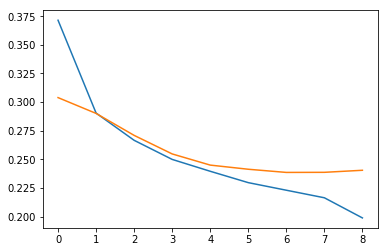

In [20]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])

## Load the model

In [23]:
from keras.models import load_model
model = load_model('my_model4.h5')

ValueError: Unknown layer: MultiPerspective

## predict the test data

In [25]:
y_pred = model.predict([X1_test, X2_test], batch_size=256)

In [26]:
# To make a submission file 
def make_submission(predict_prob):
    with open('sub4.csv', 'w') as file:
        file.write(str('y_pre') + '\n')
        for line in predict_prob:
            #line = np.clip(line, 0.005, 0.995)
            file.write(str(line[0]) + '\n')
    file.close()
    
make_submission(y_pred)